# Réalisez une application de recommandation de contenu

In [52]:
import pandas as pd
import numpy as np
from datetime import datetime
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import random
import timeit
import pickle
import math
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from azure.storage.blob import BlobServiceClient
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Import des données

In [25]:
# Metadata + embeddings des articles
NUM_EMBEDDINGS = 250

articles = pd.concat(
    [
        pd.read_csv(
            "dataset/articles_metadata.csv",
            parse_dates=["created_at_ts"],
            date_parser=lambda x: datetime.fromtimestamp(int(x) / 1000),
            dtype={
                "article_id": "category",
                "category_id": "category",
                "publisher_id": "category",
                "words_count": "int",
            },
        ),
        pd.DataFrame(
            pd.read_pickle("dataset/articles_embeddings.pickle"),
            columns=["embedding_" + str(i) for i in range(NUM_EMBEDDINGS)],
        ),
    ],
    axis=1,
)

articles = articles.astype({"created_at_ts": "datetime64[ns]"})

articles.drop(columns = ["created_at_ts", "publisher_id"], inplace = True)

In [26]:
all_files = glob.glob("dataset/clicks/*.csv")
data = []
for filename in all_files:
    df = pd.read_csv(filename, parse_dates=["session_start", "click_timestamp"],
            date_parser=lambda x: datetime.fromtimestamp(int(int(x) / 1000)),
            index_col=None, header=0)
    data.append(df)

clicks = pd.concat(data, axis=0, ignore_index=True)

clicks = clicks.astype({"session_start": "datetime64[ns]", "click_timestamp": "datetime64[ns]"})

#Indexage pour evaluation plus rapide
clicks = clicks.set_index('user_id')

Retirer les sujets qui ont trop peu d'interactions pour être pertinent

In [27]:
min_interaction = 20 #20 #200

print('Quantité d\'utilisateurs : {}'.format(len(clicks.index.unique())))
clicks['total_click'] = clicks.groupby(['user_id'])['click_article_id'].transform('count')
clicks = clicks[clicks['total_click'] >= min_interaction].reset_index()
clicks = clicks.set_index('user_id')
print('Quantité d\'utilisateurs avec au moins {} intéractions : {}'.format(min_interaction, len(clicks.index.unique())))

Quantité d'utilisateurs : 322897
Quantité d'utilisateurs avec au moins 20 intéractions : 35849


In [28]:
data = {'clicks': clicks,
       'articles': articles}

Evaluation

Issue with hitrate & cf model : recalcul de la matrice à chaque predictions pour exclure l'article tester

In [6]:
LENGHT_TOP_EVALUATION = 1000

def ModelScore(data, model, lim = None):
    
    mean_score = 0
    amplitude_score = [1, 0]
    
    #Liste d'user a parcourir
    if (lim) :
        plage = random.sample(list(data['clicks'].index.unique().values), lim)
    else:
        plage = list(data['clicks'].index.unique().values)
    
    
    for idx, user in enumerate(plage):

        # user_catchy
        articles_read = data['clicks'].loc[user]['click_article_id'].tolist()#.unique() effet sur le score ?
        articles_read_embedding = data['articles'].loc[articles_read]
        counts = articles_read_embedding['category_id'].value_counts()
        freq = articles_read_embedding['category_id'].value_counts(normalize=True)
        user_catchy = pd.DataFrame({'count': counts, 'freq': freq})
        
        #model_recomandations
        reco = model.recommend_items(user, nb = LENGHT_TOP_EVALUATION)
        
        #score
        score_for_user = 0
        reverse_i = 0
        somme_i = 0
        for i in range(LENGHT_TOP_EVALUATION, 0, -1):
            cat = reco['category_id'].loc[reverse_i]
            poids = user_catchy['freq'].loc[cat]
            score_for_user += i * poids
            somme_i += i
            reverse_i += 1
        
        score_for_user /= somme_i
        
        #update global score
        if score_for_user < amplitude_score[0]:
            amplitude_score[0] = score_for_user
        if score_for_user > amplitude_score[1]:
            amplitude_score[1] = score_for_user
        mean_score += score_for_user
                
    if (lim) :
        mean_score /= lim
    else:
        mean_score /= len(data['clicks'].index.unique())
        
    return mean_score, amplitude_score

Model de popularité (model temoin)

In [7]:
#Derterminons les plus articles les plus populaires
pop_df = clicks.copy()
pop_df['occurence'] = 1
pop_df = pop_df.groupby('click_article_id')['occurence'].sum().sort_values(ascending=False).reset_index()
pop_df

,click_article_id,occurence
0,160974,12584
1,272143,11693
2,336221,9919
3,336223,8955
4,234698,8831
...,...,...
26695,151696,1
26696,151711,1
26697,151712,1
26698,151774,1


In [8]:
class Popularity:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, data):
        self.popularity_df = popularity_df
        self.clicks = data['clicks']
        self.articles = data['articles']
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user, nb = 10):
        
        user_items = self.clicks.loc[user]['click_article_id'].tolist()
        
        reco = self.popularity_df[~self.popularity_df['click_article_id'].isin(user_items)] \
                               .sort_values('occurence', ascending = False).head(nb)
        
        reco = reco.reset_index().drop(columns=['index'])
        reco.rename(columns={'click_article_id': 'article_id'}, inplace = True)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)

        return reco
    
popularity_model = Popularity(pop_df, data)

In [9]:
popularity_model.recommend_items(5)

,article_id,occurence,category_id
0,272143,11693,399
1,336221,9919,437
2,336223,8955,437
3,234698,8831,375
4,123909,8776,250
5,96210,7832,209
6,183176,7466,301
7,331116,7208,436
8,199198,6867,323
9,272660,6847,399


Recomandations content based

In [10]:
#version plusieurs fois 1versusAll
class ContentBased_multi:
    
    MODEL_NAME = 'Content-Based'
    CUT = 5000 #ne prend pas en compte les articles predits au dela pour alleger les calculs
    
    def __init__(self, data, etudes = 10):
        self.clicks = data['clicks']
        self.articles = data['articles']  
        self.ETUDES = etudes #nombres d'articles de l'user etudiés (les plus recents)
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def get_reco_from_one(self, article_id):
        # get the  similarity scores sorted with that article
        to_sim = self.articles.drop(columns=['article_id', 'category_id', 'words_count'])
        article_sim_scores = cosine_similarity(to_sim.iloc[article_id].values.reshape(1, -1), to_sim)
        article_sim_scores = [i for i in enumerate(article_sim_scores[0])]
        article_sim_scores = sorted(list(article_sim_scores), key=lambda x: x[1], reverse=True)
        article_sim_scores = article_sim_scores[1:self.CUT+1]
        
        #get the indices & scores
        reco_indices = [i[0] for i in article_sim_scores]
        scores = [i[1] for i in article_sim_scores]        
        
        # return as df
        reco_from_one_df = pd.DataFrame()
        reco_from_one_df['article_id'] = reco_indices
        reco_from_one_df['sim_scores'] = scores
        reco_from_one_df['ranking'] = range(1, len(reco_from_one_df) + 1)
    
        return reco_from_one_df, article_sim_scores

    def get_similar_items_to_user(self, user_items):
        
        user_scores = pd.DataFrame(self.articles['article_id'])
        user_scores['sim_scores'] = 0.0

        for article_id in user_items[-self.ETUDES:]:
            reco_from_this, _ = self.get_reco_from_one(article_id)
            # aggregate the scores
            user_scores = pd.concat([user_scores, reco_from_this[['article_id', 'sim_scores']]]).groupby(['article_id'], 
                                                    as_index=False).sum({'sim_scores'})
        user_scores['sim_scores'] /= self.ETUDES
        # sort and print the aggregated scores
        user_scores = user_scores.sort_values(by='sim_scores', ascending=False)
        return user_scores        
        
    def recommend_items(self, user, nb = 10):
        
        user_items = self.clicks.loc[user]['click_article_id'].tolist()
        
        similar_items = self.get_similar_items_to_user(user_items)
        
        similar_items_filtered = similar_items[~similar_items['article_id'].isin(user_items)].reset_index()
        reco = pd.DataFrame(similar_items_filtered, columns=['article_id', 'sim_scores']).head(nb)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)

        return reco
    
cb_model_multi = ContentBased_multi(data)

In [11]:
cb_model_multi.recommend_items(5)

,article_id,sim_scores,category_id
0,159582,0.349037,281
1,161453,0.345793,281
2,157169,0.343368,281
3,157463,0.342325,281
4,157735,0.341105,281
5,160659,0.340558,281
6,156928,0.340503,281
7,158660,0.340314,281
8,153303,0.339635,281
9,149835,0.339538,278


In [12]:
#version embedding moyen user
class ContentBased_mean:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, data):
        self.clicks = data['clicks']
        self.articles = data['articles']
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def get_user_profil(self, user):
        user_clicks = self.clicks.loc[user]['click_article_id'].tolist()#self.clicks.query("user_id == @user")["click_article_id"].unique()
        user_catchy = self.articles.loc[user_clicks]
        user_profil = user_catchy.groupby(lambda x: user).mean()
        #user_profil.drop(columns=['words_count'], inplace = True)
        return user_profil

    def get_reco_from_profile(self, profile):
        # get the  similarity scores sorted with that article
        to_sim = self.articles.drop(columns=['article_id', 'category_id'])#, 'words_count'])
        article_sim_scores = cosine_similarity(profile, to_sim)
        article_sim_scores = [i for i in enumerate(article_sim_scores[0])]
        article_sim_scores = sorted(list(article_sim_scores), key=lambda x: x[1], reverse=True)
        article_sim_scores = article_sim_scores[1:]
        
        #get the indices & scores
        reco_indices = [i[0] for i in article_sim_scores]
        scores = [i[1] for i in article_sim_scores]        
        
        # return as df
        reco_from_one_df = pd.DataFrame()
        reco_from_one_df['article_id'] = reco_indices
        reco_from_one_df['sim_scores'] = scores
        reco_from_one_df['ranking'] = range(1, len(reco_from_one_df) + 1)
    
        return reco_from_one_df  
        
    def recommend_items(self, user, nb = 10):
        
        profile = self.get_user_profil(user)      
        user_items = self.clicks.loc[user]['click_article_id'].tolist()
        
        suggestions = self.get_reco_from_profile(profile)
        
        suggestions_filtered = suggestions[~suggestions['article_id'].isin(user_items)].reset_index()
        reco = pd.DataFrame(suggestions_filtered, columns=['article_id', 'sim_scores']).head(nb)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)

        return reco
    
cb_model_profile = ContentBased_mean(data)

In [64]:
cb_model_profile.recommend_items(5)

,article_id,sim_scores,category_id
0,42943,0.850485,67
1,346110,0.825724,440
2,158992,0.822549,281
3,283276,0.822176,412
4,104262,0.818104,228
5,285747,0.813707,412
6,159052,0.807657,281
7,283968,0.803702,412
8,279970,0.803550,412
9,283888,0.802668,412


Model collaborative filtering

In [6]:
#générons un rating score
def box_var(var, data):        
    sns.boxplot(x = data[var], palette = "deep")
    plt.show()
    display(pd.DataFrame(data[var].describe()))
    
def smooth_user_preference(x):
    return math.log(1+x, 2)#pas de +1?

In [7]:
#par quantité d'interactions entres utilisateurs et articles
cf_interactions_df = data['clicks'].reset_index().copy()
cf_interactions_df['strength'] = 1
cf_interactions_df = cf_interactions_df.groupby(['user_id', 'click_article_id'])['strength'].sum() \
                    .apply(smooth_user_preference).reset_index()
#cf_interactions_df = cf_interactions_df.set_index('user_id')
cf_interactions_df.head()

,user_id,click_article_id,strength
0,5,36399,1.584963
1,5,42612,1.000000
2,5,50405,1.000000
3,5,50494,1.000000
4,5,50864,1.000000


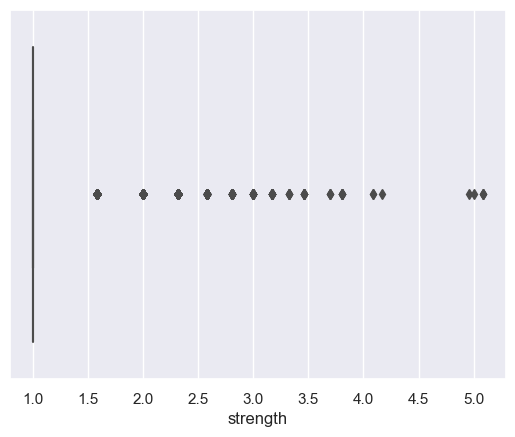

,strength
count,1.363264e+06
mean,1.011565e+00
std,8.794443e-02
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,5.087463e+00


In [16]:
box_var('strength', cf_interactions_df)

Remarque : trop peu d'interractions reproduites

In [8]:
#par temps passé sur l'articles

cf_duration_df = data['clicks'].reset_index().copy()
cf_duration_df['duration'] = cf_duration_df['click_timestamp'] - cf_duration_df['session_start']
cf_duration_df['strength'] = [td.seconds  for td in cf_duration_df['duration']]
cf_duration_df = cf_duration_df.groupby(['user_id', 'click_article_id'])['strength'].sum() \
                    .apply(smooth_user_preference).reset_index()
cf_duration_df.head()

,user_id,click_article_id,strength
0,5,36399,8.082149
1,5,42612,5.392317
2,5,50405,10.007027
3,5,50494,9.199672
4,5,50864,10.486835


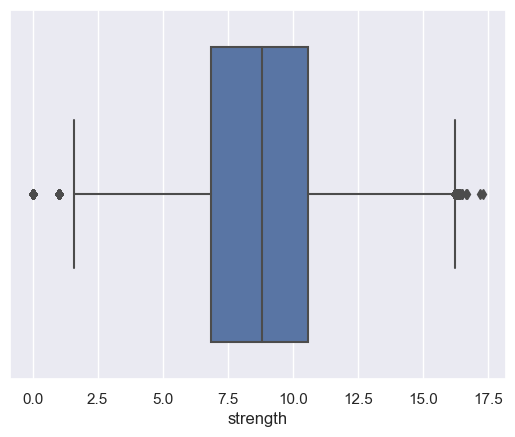

,strength
count,1.363264e+06
mean,8.750220e+00
std,2.671558e+00
min,0.000000e+00
25%,6.845490e+00
50%,8.804131e+00
75%,1.059619e+01
max,1.733166e+01


In [18]:
box_var('strength', cf_duration_df)

In [19]:
pivot_matrix_df = cf_interactions_df.pivot(index = 'user_id', columns = 'click_article_id', values = 'strength').fillna(0)
pivot_matrix_df

click_article_id,27,115,137,139,143,145,258,267,289,291,...,363978,363982,363984,363992,364001,364012,364013,364015,364017,364043
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
pivot_matrix = pivot_matrix_df.values
users_ids = list(pivot_matrix_df.index)

pivot_sparse_matrix = csr_matrix(pivot_matrix)
pivot_sparse_matrix

<35849x26700 sparse matrix of type '<class 'numpy.float64'>'
	with 1363264 stored elements in Compressed Sparse Row format>

In [10]:
NUMBER_OF_FACTORS_MF = 15
U, sigma, Vt = svds(pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
sigma = np.diag(sigma)

In [22]:
all_user_predictions = np.dot(np.dot(U, sigma), Vt) 
all_user_predictions = (all_user_predictions - all_user_predictions.min()) / (all_user_predictions.max() - all_user_predictions.min())
cf_interactions_final = pd.DataFrame(all_user_predictions, columns = pivot_matrix_df.columns, index = users_ids).transpose()
cf_interactions_final

,5,6,7,8,10,11,12,16,17,19,...,308772,310654,313176,314941,315007,315483,315667,316121,319538,321475
click_article_id,,,,,,,,,,,,,,,,,,,,,
27,0.250032,0.250021,0.250019,0.250021,0.250025,0.250025,0.250017,0.250021,0.250025,0.250013,...,0.250020,0.250023,0.250022,0.250022,0.250018,0.250018,0.250022,0.250021,0.250021,0.250021
115,0.250114,0.250206,0.250020,0.250087,0.250020,0.250074,0.250051,0.250037,0.250032,0.249976,...,0.250052,0.250058,0.250053,0.250050,0.250085,0.250088,0.250054,0.250096,0.250055,0.250021
137,0.250012,0.250022,0.250043,0.250056,0.250010,0.250031,0.250015,0.250043,0.250052,0.250044,...,0.250028,0.249997,0.250029,0.250006,0.249989,0.249989,0.250010,0.249986,0.250006,0.250021
139,0.250034,0.250070,0.250010,0.250033,0.249993,0.250014,0.250044,0.250003,0.250000,0.250009,...,0.250043,0.250067,0.250029,0.250062,0.250098,0.250103,0.250059,0.250099,0.250064,0.250021
143,0.250012,0.250022,0.250043,0.250056,0.250010,0.250031,0.250015,0.250043,0.250052,0.250044,...,0.250028,0.249997,0.250029,0.250006,0.249989,0.249989,0.250010,0.249986,0.250006,0.250021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364012,0.250048,0.249980,0.250060,0.250065,0.250024,0.250006,0.250085,0.250034,0.250051,0.250025,...,0.250054,0.250093,0.250030,0.250089,0.250136,0.250139,0.250085,0.250137,0.250094,0.250021
364013,0.250048,0.249980,0.250060,0.250065,0.250024,0.250006,0.250085,0.250034,0.250051,0.250025,...,0.250054,0.250093,0.250030,0.250089,0.250136,0.250139,0.250085,0.250137,0.250094,0.250021
364015,0.250048,0.249980,0.250060,0.250065,0.250024,0.250006,0.250085,0.250034,0.250051,0.250025,...,0.250054,0.250093,0.250030,0.250089,0.250136,0.250139,0.250085,0.250137,0.250094,0.250021


In [11]:
pivot_matrix_df = cf_duration_df.pivot(index = 'user_id', columns = 'click_article_id', values = 'strength').fillna(0)
pivot_matrix = pivot_matrix_df.values
users_ids = list(pivot_matrix_df.index)
pivot_sparse_matrix = csr_matrix(pivot_matrix)
U, sigma, Vt = svds(pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
sigma = np.diag(sigma)
all_user_predictions = np.dot(np.dot(U, sigma), Vt) 
all_user_predictions = (all_user_predictions - all_user_predictions.min()) / (all_user_predictions.max() - all_user_predictions.min())
cf_duration_final = pd.DataFrame(all_user_predictions, columns = pivot_matrix_df.columns, index = users_ids).transpose()
cf_duration_final

,5,6,7,8,10,11,12,16,17,19,...,308772,310654,313176,314941,315007,315483,315667,316121,319538,321475
click_article_id,,,,,,,,,,,,,,,,,,,,,
27,0.344697,0.344689,0.344687,0.344689,0.344694,0.344691,0.344685,0.344686,0.344689,0.344688,...,0.344689,0.344691,0.344691,0.344690,0.344688,0.344688,0.344690,0.344690,0.344689,0.344689
115,0.344795,0.344791,0.344654,0.344709,0.344718,0.344745,0.344658,0.344766,0.344755,0.344668,...,0.344721,0.344734,0.344772,0.344732,0.344761,0.344791,0.344746,0.344775,0.344745,0.344689
137,0.344683,0.344690,0.344698,0.344702,0.344685,0.344695,0.344686,0.344702,0.344703,0.344698,...,0.344692,0.344681,0.344697,0.344684,0.344676,0.344672,0.344685,0.344676,0.344681,0.344689
139,0.344693,0.344763,0.344638,0.344703,0.344655,0.344702,0.344670,0.344639,0.344632,0.344696,...,0.344714,0.344734,0.344726,0.344728,0.344779,0.344817,0.344737,0.344780,0.344745,0.344689
143,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,...,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364012,0.344738,0.344645,0.344759,0.344768,0.344700,0.344673,0.344759,0.344695,0.344744,0.344691,...,0.344737,0.344786,0.344711,0.344781,0.344887,0.344947,0.344802,0.344874,0.344836,0.344689
364013,0.344738,0.344644,0.344759,0.344768,0.344700,0.344673,0.344759,0.344695,0.344745,0.344691,...,0.344738,0.344787,0.344711,0.344782,0.344888,0.344948,0.344803,0.344875,0.344836,0.344689
364015,0.344738,0.344645,0.344759,0.344768,0.344700,0.344673,0.344759,0.344695,0.344744,0.344691,...,0.344737,0.344786,0.344711,0.344781,0.344887,0.344947,0.344802,0.344874,0.344836,0.344689


In [24]:
class CollaborativeFiltering:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_preds_df, data):
        self.predictions = cf_preds_df
        self.articles = data['articles']
        self.clicks = data['clicks']
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user, nb = 10):     
        
        user_items = self.clicks.loc[user]['click_article_id'].tolist()
        
        sorted_predictions = self.predictions[user].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user: 'strength'})

        reco = sorted_predictions[~sorted_predictions['click_article_id'].isin(user_items)] \
                                .sort_values('strength', ascending = False) \
                                .reset_index().drop(columns=['index']).head(nb)
        reco.rename(columns={'click_article_id': 'article_id'}, inplace = True)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)

        return reco
    
cf_model_interactions = CollaborativeFiltering(cf_interactions_final, data)
cf_model_duration = CollaborativeFiltering(cf_duration_final, data)

In [25]:
cf_model_interactions.recommend_items(5)

,article_id,strength,category_id
0,158536,0.350827,281
1,160417,0.340978,281
2,156560,0.336590,281
3,289003,0.314787,418
4,159762,0.313992,281
5,161506,0.307042,281
6,183176,0.301228,301
7,235854,0.300038,375
8,156624,0.298210,281
9,331116,0.298091,436


In [26]:
cf_model_duration.recommend_items(5)

,article_id,strength,category_id
0,158536,0.431651,281
1,156560,0.416185,281
2,160417,0.415589,281
3,183176,0.404016,301
4,331116,0.401308,436
5,289003,0.398706,418
6,161506,0.393644,281
7,336254,0.390732,437
8,157478,0.389688,281
9,202355,0.386721,327


Model Hybrid

In [27]:
class Hybrid:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_model, cf_model, data, cb_weight = 1.0, cf_weight = 1.0):
        self.cb = cb_model
        self.cf = cf_model
        self.cb_weight = cb_weight
        self.cf_weight = cf_weight
        self.articles = data['articles']
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user, nb = 10):
               
        NB = 100 * nb
        #Getting the top Content-based filtering recommendations
        cb_reco_df = self.cb.recommend_items(user, nb = NB) \
        .rename(columns = {'sim_scores': 'strength_CB'}).drop(columns = ['category_id'])
        #cb_reco_df = normalisation_reco(cb_reco_df)
        
        #Getting the top Collaborative filtering recommendations
        cf_reco_df = self.cf.recommend_items(user, nb = NB) \
        .rename(columns = {'strength': 'strength_CF'}).drop(columns = ['category_id'])
        #cf_reco_df = normalisation_reco(cf_reco_df)
        
        #Combining the results by contentId
        reco_df = cb_reco_df.merge(cf_reco_df,
                                   how = 'outer', 
                                   left_on = 'article_id', 
                                   right_on = 'article_id').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        reco_df['strength_Hybrid'] = (reco_df['strength_CB'] * self.cb_weight) \
                                     + (reco_df['strength_CF'] * self.cf_weight)
        
        #Sorting recommendations by hybrid score
        reco = reco_df.sort_values('strength_Hybrid', ascending = False) \
        .reset_index().drop(columns=['index']).head(nb)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)
     
        return reco
    
hybrid_model = Hybrid(cb_model_profile, cf_model_interactions, data, cb_weight = 1.0, cf_weight = 1.0)

In [28]:
hybrid_model.recommend_items(5)

,article_id,strength_CB,strength_CF,strength_Hybrid,category_id
0,205873,0.785447,0.258230,1.043677,331
1,284705,0.783764,0.254935,1.038699,412
2,285719,0.766582,0.270560,1.037142,412
3,285045,0.751628,0.256380,1.008008,412
4,160453,0.743103,0.264125,1.007228,281
5,284491,0.749524,0.255720,1.005243,412
6,283608,0.750947,0.253202,1.004149,412
7,286161,0.729472,0.273345,1.002817,412
8,285101,0.739009,0.254263,0.993271,412
9,207760,0.736770,0.255272,0.992042,331


Tests

In [29]:
def confront(grid, eval_lim = 1000):
    comparateur = pd.DataFrame(columns = ['category_id_Score', 'min_score', 'max_score', 'EXE time'])

    for g in grid:
        print(g)
        start_time = timeit.default_timer()
        cat_score, ampli = ModelScore(data, grid[g], lim = eval_lim)
        elapsed = timeit.default_timer() - start_time
        print(elapsed)
        time = round(elapsed, 2)
        res_to_df = pd.DataFrame([[cat_score, ampli[0], ampli[1], time]],
                                index=[g],
                                columns = ['category_id_Score', 'min_score', 'max_score', 'EXE time'])
        comparateur = comparateur.append(res_to_df)
        
    #comparateur = comparateur.sort_values(by=['category_id_Score'])
    #time * score
    return comparateur

In [31]:
grid = {}
grid['Popularity'] = Popularity(pop_df, data)
for e in [10, 50, 100]:
    grid['CB_multi_etudes_'+str(e)] = ContentBased_multi(data, etudes = e)
grid['CB_mean'] = ContentBased_mean(data)
grid['CF_interactions'] = CollaborativeFiltering(cf_interactions_final, data)
grid['CF_duration'] = CollaborativeFiltering(cf_duration_final, data)
grid

{'Popularity': <__main__.Popularity at 0x1eb07f11370>,
 'CB_multi_etudes_10': <__main__.ContentBased_multi at 0x1eb07f112e0>,
 'CB_multi_etudes_50': <__main__.ContentBased_multi at 0x1eb07f11400>,
 'CB_multi_etudes_100': <__main__.ContentBased_multi at 0x1eb07f111f0>,
 'CB_mean': <__main__.ContentBased_mean at 0x1eb07f11340>,
 'CF_interactions': <__main__.CollaborativeFiltering at 0x1eb07f11310>,
 'CF_duration': <__main__.CollaborativeFiltering at 0x1eb07f11040>}

In [32]:
test5 = confront(grid, eval_lim = 5) 

Popularity
0.3066748999999902
CB_multi_etudes_10
77.57881850000004
CB_multi_etudes_50
277.00485999999995
CB_multi_etudes_100
231.08147169999995
CB_mean
8.634260799999993
CF_interactions
0.3904758999999558
CF_duration
0.39303639999991447


In [33]:
test5

,category_id_Score,min_score,max_score,EXE time
Popularity,0.040399,0.025065,0.051458,0.31
CB_multi_etudes_10,0.103717,0.027117,0.331690,77.58
CB_multi_etudes_50,0.178776,0.099417,0.273156,277.00
CB_multi_etudes_100,0.152048,0.054105,0.287702,231.08
CB_mean,0.151757,0.058590,0.256526,8.63
CF_interactions,0.057143,0.034666,0.077082,0.39
CF_duration,0.038473,0.008152,0.058377,0.39


In [34]:
test100 = confront(grid, eval_lim = 100) 

Popularity
6.709453999999937
CB_multi_etudes_10
1534.2927826999999
CB_multi_etudes_50
5004.1652572
CB_multi_etudes_100
5962.0757853
CB_mean
171.83457760000056
CF_interactions
5.986227700001109
CF_duration
7.096868299999187


In [35]:
test100

,category_id_Score,min_score,max_score,EXE time
Popularity,0.038715,0.006078,0.075551,6.71
CB_multi_etudes_10,0.138412,0.006770,0.790245,1534.29
CB_multi_etudes_50,0.198139,0.017749,0.793313,5004.17
CB_multi_etudes_100,0.167150,0.016078,0.666043,5962.08
CB_mean,0.134114,0.022560,0.645183,171.83
CF_interactions,0.047533,0.020702,0.162850,5.99
CF_duration,0.045831,0.011971,0.124636,7.10


In [41]:
grid2 = {}
for w in [0.5, 1, 1.5, 2]:
    grid2['Hybrid_'+str(w)] = Hybrid(grid['CB_mean'], grid['CF_interactions'], data, cb_weight = 1.0, cf_weight = w)
grid2

{'Hybrid_0.5': <__main__.Hybrid at 0x1eb0802c730>,
 'Hybrid_1': <__main__.Hybrid at 0x1eb07ed5940>,
 'Hybrid_1.5': <__main__.Hybrid at 0x1eb07ed5730>,
 'Hybrid_2': <__main__.Hybrid at 0x1eb07ed5c10>}

In [42]:
test5 = confront(grid2, eval_lim = 5) 

Hybrid_0.5
9.122140800000125
Hybrid_1
9.088379999999233
Hybrid_1.5
9.386355200000253
Hybrid_2
9.13328619999993


In [43]:
test5

,category_id_Score,min_score,max_score,EXE time
Hybrid_0.5,0.213255,0.032505,0.475947,9.12
Hybrid_1,0.075857,0.031503,0.121917,9.09
Hybrid_1.5,0.085174,0.042598,0.132822,9.39
Hybrid_2,0.099237,0.075365,0.147627,9.13


In [44]:
test100 = confront(grid2, eval_lim = 100) 

Hybrid_0.5
181.5222520999996
Hybrid_1
182.09173929999997
Hybrid_1.5
181.44234209999922
Hybrid_2
182.9609017999992


In [45]:
test100

,category_id_Score,min_score,max_score,EXE time
Hybrid_0.5,0.131416,0.019491,0.832148,181.52
Hybrid_1,0.118451,0.017732,0.693217,182.09
Hybrid_1.5,0.123910,0.031038,0.468930,181.44
Hybrid_2,0.130374,0.019458,0.632704,182.96


In [46]:
#test100.to_csv('test_hybrid100.csv')

In [ ]:
grid = {}
grid['Popularity'] = Popularity(pop_df, data)
for e in [10, 100]:
    grid['CB_multi_etudes_'+str(e)] = ContentBased_multi(data, etudes = e)
grid['CB_mean'] = ContentBased_mean(data)
grid['CF_interactions'] = CollaborativeFiltering(cf_interactions_final, data)
grid['CF_duration'] = CollaborativeFiltering(cf_duration_final, data)
grid

In [ ]:
test5000 = confront(grid, eval_lim = 5000) 

In [ ]:
test5000

In [51]:
grid2 = {}
for w in [0.5, 1, 1.5, 2, 3]:
    grid2['Hybrid_'+str(w)] = Hybrid(grid['CB_mean'], grid['CF_interactions'], data, cb_weight = 1.0, cf_weight = w)
grid2

{'Hybrid_0.5': <__main__.Hybrid at 0x1eb07c395b0>,
 'Hybrid_1': <__main__.Hybrid at 0x1eb0ee72ee0>,
 'Hybrid_1.5': <__main__.Hybrid at 0x1eb07c66760>,
 'Hybrid_2': <__main__.Hybrid at 0x1eb07eaef40>,
 'Hybrid_3': <__main__.Hybrid at 0x1eb07eaec70>}

In [53]:
test25000 = confront(grid2, eval_lim = 1000) 

Hybrid_0.5
1804.1064479999986
Hybrid_1
1803.2151234000012
Hybrid_1.5
1802.472443499999
Hybrid_2
1803.9320703000012
Hybrid_3
1805.1095256000008


In [54]:
test25000

,category_id_Score,min_score,max_score,EXE time
Hybrid_0.5,0.132521,0.019276,0.875256,1804.11
Hybrid_1,0.122052,0.015070,0.848616,1803.22
Hybrid_1.5,0.118367,0.012478,0.736797,1802.47
Hybrid_2,0.122623,0.012020,0.625064,1803.93
Hybrid_3,0.120943,0.020619,0.673194,1805.11


In [56]:
test25000.to_csv('test_hybrid1000.csv')

In [30]:
grid = {}
grid['CF_interactions'] = CollaborativeFiltering(cf_interactions_final, data)
grid['CF_duration'] = CollaborativeFiltering(cf_duration_final, data)
grid

{'CF_interactions': <__main__.CollaborativeFiltering at 0x2b90f6c8310>,
 'CF_duration': <__main__.CollaborativeFiltering at 0x2b90f6c8850>}

In [31]:
test10k = confront(grid, eval_lim = 10000)

CF_interactions
671.8051298
CF_duration
389.2871639


In [32]:
test10k

,category_id_Score,min_score,max_score,EXE time
CF_interactions,0.046698,0.000000,0.207032,671.81
CF_duration,0.045943,0.000172,0.167983,389.29


Data look

In [ ]:
clicks

In [ ]:
articles

Upload to Azure blob storage

In [14]:
connect_str = "DefaultEndpointsProtocol=https;AccountName=p9teststockage;AccountKey=AI0GHZZor7+Sg6MxDQvBoL1NtdEMhQA3mqxB98r+I3Oj6fZ/B3oeQ44uW/2SJxP/4XA4xfyqbs/X+ASti4jVPg==;EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [ ]:
#Réduction du df clicks

In [36]:
clicks = data['clicks'].reset_index()
clicks = clicks[['user_id', 'click_article_id']]

In [37]:
output = clicks.to_csv(index=False, encoding="utf-8")
upload_file_path = "P9_chaleyssin_nicolas/clicks"
blob_client = blob_service_client.get_blob_client(container="dftoblob", blob=upload_file_path)
blob_client.upload_blob(output, blob_type="BlockBlob")

{'etag': '"0x8DB08F34710C1A7"',
 'last_modified': datetime.datetime(2023, 2, 7, 10, 8, 36, tzinfo=datetime.timezone.utc),
 'content_md5': bytearray(b'&_\x05\xfd\xfe0=Q=\n{F\xa0 ]\xf6'),
 'client_request_id': '5d0d1af7-a6cf-11ed-bdf3-00155dd3cb12',
 'request_id': '7d6336d9-801e-0004-48dc-3a95a7000000',
 'version': '2021-08-06',
 'version_id': None,
 'date': datetime.datetime(2023, 2, 7, 10, 8, 35, tzinfo=datetime.timezone.utc),
 'request_server_encrypted': True,
 'encryption_key_sha256': None,
 'encryption_scope': None}

In [40]:
#Réduction du df articles via PCA
only_embedding = data["articles"].iloc[:,3:]
pca = PCA(n_components=75)
pca.fit(only_embedding)
embedding_pca = pca.transform(only_embedding)
embedding_pca = pd.DataFrame(embedding_pca, 
                                      columns = ["embedding_" + str(i) for i in range(embedding_pca.shape[1])])
articles = data["articles"].iloc[:,:1].merge(embedding_pca, how = 'left', right_index = True, left_index = True)
sum(pca.explained_variance_ratio_)

0.9800583633392728

In [42]:
output = articles.to_csv(index=False, encoding="utf-8")
upload_file_path = "P9_chaleyssin_nicolas/articles"
blob_client = blob_service_client.get_blob_client(container="dftoblob", blob=upload_file_path)
blob_client.upload_blob(output, blob_type="BlockBlob")

{'etag': '"0x8DB08F406D3B3E2"',
 'last_modified': datetime.datetime(2023, 2, 7, 10, 13, 58, tzinfo=datetime.timezone.utc),
 'content_md5': None,
 'content_crc64': bytearray(b'\x91\xd4c\x11K.\xa5\xe3'),
 'client_request_id': '226396af-a6d0-11ed-b5bc-00155dd3cb12',
 'request_id': '7d661371-801e-0004-41dc-3a95a7000000',
 'version': '2021-08-06',
 'version_id': None,
 'date': datetime.datetime(2023, 2, 7, 10, 13, 57, tzinfo=datetime.timezone.utc),
 'request_server_encrypted': True,
 'encryption_key_sha256': None,
 'encryption_scope': None}

In [50]:
l = clicks[clicks['user_id']==5]['click_article_id'].tolist()
articles.loc[l]

,article_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_65,embedding_66,embedding_67,embedding_68,embedding_69,embedding_70,embedding_71,embedding_72,embedding_73,embedding_74
168868,168868,1.552445,-0.832865,-2.614630,0.285832,-1.329027,0.673966,-2.908709,1.366382,-0.351730,...,0.055606,-0.053506,0.165671,-0.021341,0.144461,0.337331,0.010704,0.036098,-0.054176,-0.092012
207122,207122,2.311328,-0.473118,-0.155147,-0.412353,2.429025,2.227056,-1.177098,1.453048,0.018394,...,-0.010702,0.035138,0.005580,0.323173,0.008957,0.015417,-0.174433,-0.116027,0.210019,0.026015
286413,286413,0.947146,2.999506,0.436401,1.111729,1.766930,-1.088825,1.754214,1.608627,0.746054,...,0.302752,-0.164963,0.038544,-0.002180,-0.032487,-0.043284,-0.103714,-0.157331,-0.229808,0.185631
156543,156543,2.996418,-0.472111,0.784028,-1.931117,0.018517,-1.068001,-1.877746,-2.468303,0.626750,...,0.059936,0.167490,0.174953,0.025380,-0.098313,-0.235127,-0.038265,-0.426678,-0.220514,-0.039134
284664,284664,-0.315626,1.856887,-0.061846,0.458286,3.546686,-0.691931,1.727734,-0.717560,0.993870,...,-0.130466,0.180459,-0.245181,0.124869,0.093921,0.064527,0.026059,0.117674,0.066607,-0.102951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50405,50405,3.686004,0.437171,0.283934,-1.142012,-0.884555,-0.111025,-1.066097,-1.937835,0.433690,...,-0.245149,-0.239094,-0.102752,0.029613,-0.090910,-0.244339,-0.054479,0.180246,0.219109,-0.119015
73506,73506,2.581856,-0.655720,-0.600820,-0.862310,0.336055,0.680653,0.205496,-0.272082,-0.180854,...,-0.176006,0.158158,-0.031141,0.320158,0.134921,0.155546,-0.056690,0.099536,-0.031546,0.033290
65839,65839,2.664311,1.306578,-0.165233,-0.882883,0.627611,0.758916,-0.246201,-1.671081,0.277333,...,-0.196484,0.154702,-0.023154,-0.069136,-0.143623,-0.221188,-0.084562,0.232624,0.026350,-0.130687
156279,156279,3.166576,-0.585796,0.610347,-1.553900,0.158979,-0.328110,-0.640311,-2.603567,0.825605,...,-0.035776,0.249581,0.049265,0.037375,0.113779,0.194990,0.451106,-0.016831,-0.169221,0.082388


In [ ]:
output = cf_duration_final.to_csv(index=False, encoding="utf-8")
upload_file_path = "P9_chaleyssin_nicolas/duration"
blob_client = blob_service_client.get_blob_client(container="dftoblob", blob=upload_file_path)
blob_client.upload_blob(output, blob_type="BlockBlob")